In [1]:
# -*- coding: utf8 -*-


from sirsaia import brasilio
from sirsaia import epiestim
from sirsaia import plotutils


import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
plt.ion()
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize']  = (12, 8)

In [3]:
config = epiestim.make_config(mean_si=4.8, std_si=2.3, si_parametric_distr='weibull')

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


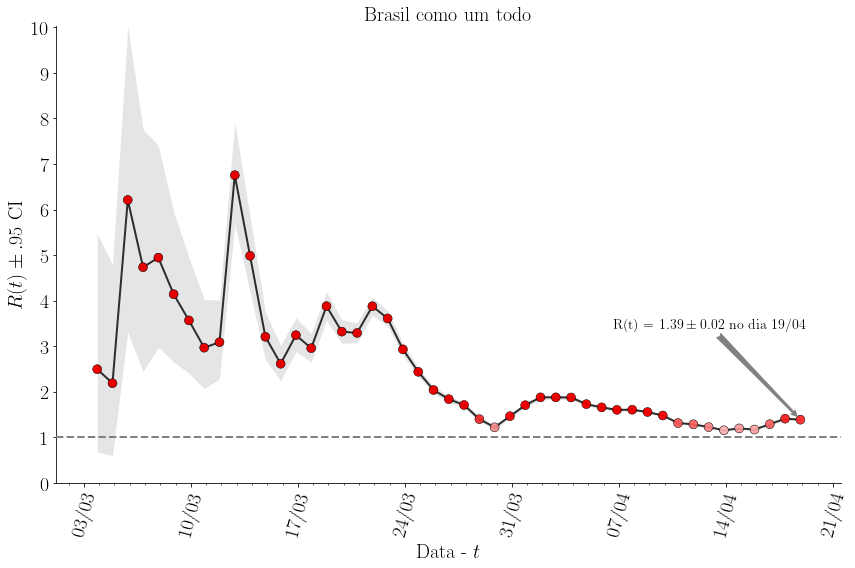

In [4]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
brazil = df_orig[df_orig['Country/Region'] == 'Brazil'].T
brazil = brazil[4:].copy()
brazil.index = pd.to_datetime(brazil.index)
brazil = brazil.sort_index().astype('i').diff().fillna(0)
first_day = np.nonzero(brazil.values)[0][0]
brazil = brazil[first_day:]
brazil.columns = ['local']
epiestim_result = epiestim.estimate_r(brazil, config)
plt.title('Brasil como um todo')
plotutils.plot_result(epiestim_result, brazil)
plt.tight_layout()
plt.savefig('plots/Brasil.png')
plt.show()

epiestim_result['t_start'] = brazil.index[(epiestim_result['t_start'] - 1).astype('i').values]
epiestim_result['t_end'] = brazil.index[(epiestim_result['t_end'] - 1).astype('i').values]
epiestim_result['country'] = 'Brazil'
epiestim_result['state'] = np.nan
epiestim_result['city'] = np.nan
epiestim_result.to_csv('results.csv', mode='w', header=True, index=False)

In [5]:
def get_state(full_df, state):
    work_df = full_df[['state', 'city', 'place_type', 'confirmed']].copy()
    work_df.index = pd.to_datetime(full_df['date'])
    work_df = work_df.sort_index()

    idx = (work_df['state'] == state) & (work_df['place_type'] == 'state')
    state_df = work_df[idx]
    first_day = np.nonzero(state_df.values)[0][0]
    state_df = state_df[first_day:]
    
    first = state_df['confirmed'].iloc[0]
    state_df['confirmed'] = state_df['confirmed'].diff().fillna(0)
    state_df['confirmed'][state_df['confirmed'] < 0] = 0
    state_df['confirmed'].values[0] = first

    idx = (work_df['state'] == state) & (work_df['city'] == 'Importados/Indefinidos')
    imported_df = work_df[idx]['confirmed']
    
    state_df['imported'] = imported_df
    state_df = state_df.rename(columns={'confirmed': 'local'}).fillna(0)
    last_day = np.nonzero(state_df['local'].values)[0][-1]
    
    return state_df.iloc[:last_day+1].copy()

In [6]:
def get_city(full_df, state, city):
    work_df = full_df[['state', 'city', 'place_type', 'confirmed']].copy()
    work_df.index = pd.to_datetime(full_df['date'])
    work_df = work_df.sort_index()

    idx = (work_df['state'] == state) & (work_df['city'] == city)
    city_df = work_df[idx]
    first_day = np.nonzero(city_df.values)[0][0]
    city_df = city_df[first_day:]
    
    first = city_df['confirmed'].iloc[0]
    city_df['confirmed'] = city_df['confirmed'].diff().fillna(0)
    city_df['confirmed'][city_df['confirmed'] < 0] = 0
    city_df['confirmed'].values[0] = first
    
    city_df = city_df.rename(columns={'confirmed': 'local'}).fillna(0)
    last_day = np.nonzero(city_df['local'].values)[0][-1]
    
    
    return city_df.iloc[:last_day+1].copy()

In [7]:
full_df = pd.read_csv('https://data.brasil.io/dataset/covid19/caso.csv.gz')

In [8]:
regions = {'Centro-Oeste': ['DF', 'GO', 'MS', 'MT'],
          'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'], 
          'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
          'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
          'Sul': ['PR', 'RS', 'SC']}

In [9]:
pop = pd.read_csv('data/populacao-estimada-2019.csv')

In [10]:
mr = []
for region in regions:
    for state in regions[region]:
        model_df = get_state(full_df, state)[['local']].copy()
        epiestim_result = epiestim.estimate_r(model_df, config)
        plotutils.plot_result(epiestim_result, model_df)
        plt.title(state) #+ ' last mean = {}'.format(epiestim_result['Mean(R)'].values[-1]))
        try:
            os.makedirs('plots/{}/'.format(region))
        except:
            pass
        plt.tight_layout()
        plt.savefig('plots/{}/{}.png'.format(region, state))
        plt.close()
        
        epiestim_result['t_start'] = model_df.index[(epiestim_result['t_start'] - 1).astype('i').values]
        epiestim_result['t_end'] = model_df.index[(epiestim_result['t_end'] - 1).astype('i').values]
        epiestim_result['country'] = 'Brazil'
        epiestim_result['state'] = state
        epiestim_result['city'] = np.nan
        epiestim_result.to_csv('results.csv', mode='a', header=False, index=False)
        
        mr.append({'state': state,
                   'low': epiestim_result.iloc[-1]['Quantile.0.025(R)'],
                   'mid': epiestim_result.iloc[-1]['Mean(R)'],
                   'high': epiestim_result.iloc[-1]['Quantile.0.975(R)']
                  })
        
        top_5 = pop[pop['uf'] == state].sort_values(by='populacao_estimada')[-5:]['municipio']
        for city in top_5.values:
            try:
                model_df = get_city(full_df, state, city)[['local']].copy()
                epiestim_result = epiestim.estimate_r(model_df, config)        
                plotutils.plot_result(epiestim_result, model_df)
                plt.title(state + '-' + city)
                plt.tight_layout()
                plt.savefig('plots/{}/{}-{}.png'.format(region, state, city))
                plt.close()

                epiestim_result['t_start'] = model_df.index[(epiestim_result['t_start'] - 1).astype('i').values]
                epiestim_result['t_end'] = model_df.index[(epiestim_result['t_end'] - 1).astype('i').values]
                epiestim_result['country'] = 'Brazil'
                epiestim_result['state'] = state
                epiestim_result['city'] = city
                epiestim_result.to_csv('results.csv', mode='a', header=False)
            except:
                pass

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-10 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-12 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-18 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-17 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-08 00:00:00
2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-17 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarnin

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-18 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-18 00:00:00
2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarnin

2020-04-17 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00
2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_l

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarnin

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarnin

2020-04-17 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-15 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-15 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-16 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Error in check_times(config$t_start, config$t_end, T) : 
  t_start must be a vector of integers between 2 and the number of 
         timesteps in incid.

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinter

2020-04-08 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-18 00:00:00
2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/p

2020-04-18 00:00:00
2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-20 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-20 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-20 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-20 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


2020-04-19 00:00:00
2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-16 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-17 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-18 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-16 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-17 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


2020-04-19 00:00:00


In [11]:
mr = pd.DataFrame(mr)
mr = mr.set_index('state')

In [12]:
mr

,low,mid,high
state,,,
DF,1.243898,1.416401,1.599943
GO,1.053922,1.235206,1.430665
MS,1.317189,1.696231,2.122474
MT,0.681104,0.911971,1.176015
AL,2.205934,2.679066,3.197480
BA,1.499871,1.630310,1.766110
CE,1.577349,1.658645,1.741954
MA,1.898032,2.030270,2.166898
PB,1.105775,1.318857,1.550434


In [13]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

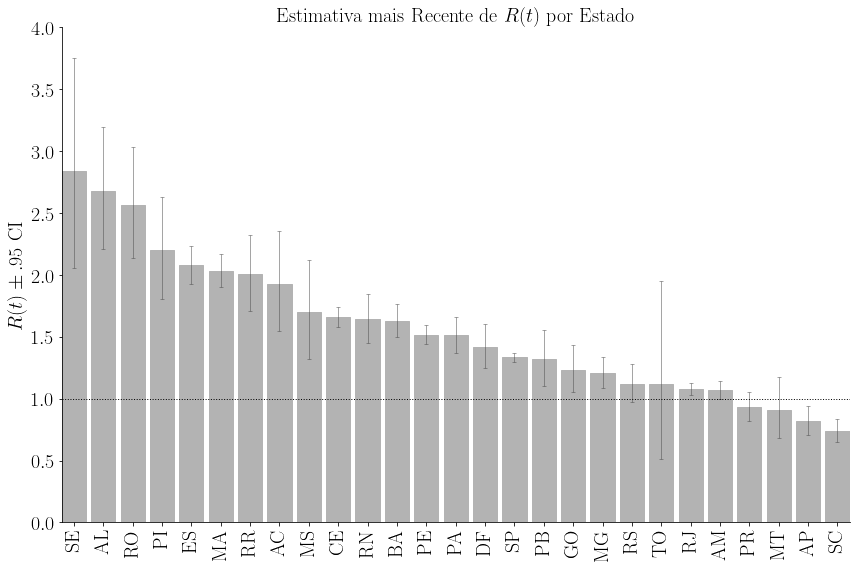

In [14]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


def plot_standings(mr, title='Estimativa mais Recente de $R(t)$ por Estado'):
    plt.title(title)
    err = mr[['low', 'high']].sub(mr['mid'], axis=0).abs()
    bars = plt.bar(mr.index,
                  mr['mid'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        bar.set_color([.7,.7,.7])
        
    labels = mr.index
    ax = plt.gca()
    ax.set_xticklabels(labels, rotation=90)
    ax.margins(0)
    ax.set_ylim(0, 4)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    #leg = ax.legend(handles=[
    #                    Patch(label='Full', color=FULL_COLOR),
    #                    Patch(label='Partial', color=PARTIAL_COLOR),
    #                    Patch(label='None', color=NONE_COLOR)
    #                ],
    #                title='Lockdown',
    #                ncol=3,
    #                loc='upper left',
    #                columnspacing=.75,
    #                handletextpad=.5,
    #                handlelength=1)

    #leg._legend_box.align = "left"
    #fig.set_facecolor('w')
    despine()
    plt.ylabel(r'$R(t) \pm .95$ CI')
    plt.tight_layout()
    plt.savefig('./plots/comparativo.png')
    
mr.sort_values('mid', inplace=True, ascending=False)
plot_standings(mr);

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


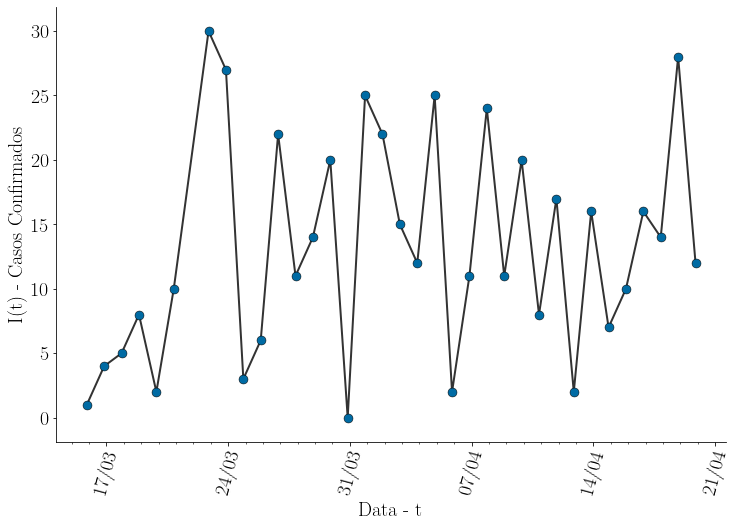

In [15]:
bh = get_city(full_df, 'MG', 'Belo Horizonte')
#bh['local'].plot.bar()

plt.plot(bh.index, bh.local, c='k', zorder=1, alpha=.8)
plt.scatter(bh.index, bh.local, s=80, lw=.5, edgecolors='k', zorder=2)
    
import pytz
import matplotlib.dates as mdates

brt = pytz.timezone('America/Sao_Paulo')

ax = plt.gca()
ax.xaxis_date(tz=brt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(tz=brt))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz=brt))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m', tz=brt))
plt.xticks(rotation=75)

plt.ylabel('I(t) - Casos Confirmados')
plt.xlabel('Data - t')

plotutils.despine()

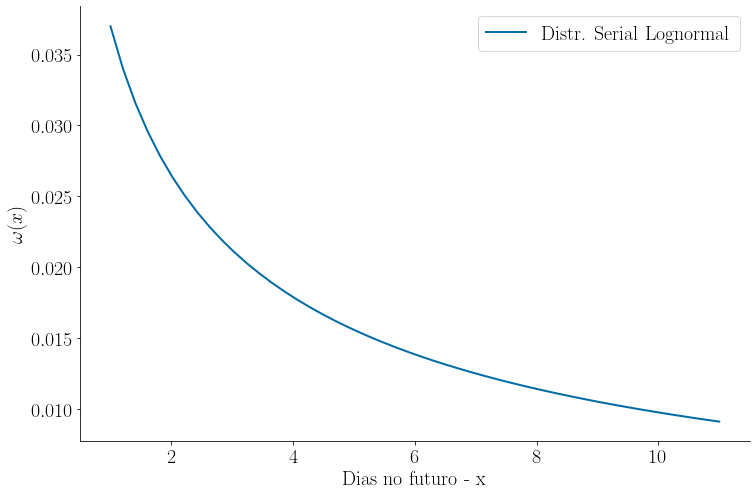

In [16]:
from scipy import stats as ss

ln = ss.distributions.lognorm(s=2.9, scale=np.exp(4.7))
x = np.linspace(1, 11)
plt.plot(x, ln.pdf(x), label='Distr. Serial Lognormal')
plt.ylabel(r'$\omega(x)$')
plt.xlabel('Dias no futuro - x')
plt.legend()
plotutils.despine()

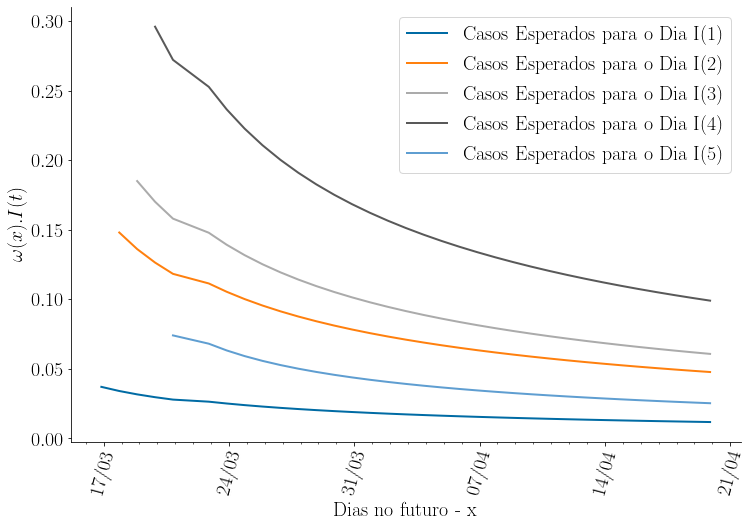

In [17]:
cumsum = bh.local[0] * ln.pdf(x)
n = bh.index.shape[0]
plt.plot(bh.index[1:], bh.local[0] * ln.pdf(x)[:n-1],
         label='Casos Esperados para o Dia I(1)')
for i in range(1, 5):
    n = bh.index[i:].shape[0]
    plt.plot(bh.index[i+1:], bh.local[i] * ln.pdf(x[:n-1]),
             label='Casos Esperados para o Dia I({})'.format(i+1))
    cumsum += bh.local[i] * ln.pdf(x)
plt.ylabel(r'$\omega(x) . I(t)$')
plt.xlabel('Dias no futuro - x')
plt.legend()

ax = plt.gca()
ax.xaxis_date(tz=brt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(tz=brt))
ax.xaxis.set_minor_locator(mdates.DayLocator(tz=brt))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m', tz=brt))
plt.xticks(rotation=75)

plotutils.despine()

In [18]:
full_df[(full_df['state'] == 'MG') & (full_df['city'] == 'Belo Horizonte')]

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
18867,2020-04-20,MG,Belo Horizonte,city,460,8,35,True,2512070.0,3106200.0,18.31159,0.0174
18868,2020-04-19,MG,Belo Horizonte,city,448,8,34,False,2512070.0,3106200.0,17.83390,0.0179
18869,2020-04-18,MG,Belo Horizonte,city,420,8,33,False,2512070.0,3106200.0,16.71928,0.0190
18870,2020-04-17,MG,Belo Horizonte,city,406,8,32,False,2512070.0,3106200.0,16.16197,0.0197
18871,2020-04-16,MG,Belo Horizonte,city,390,7,31,False,2512070.0,3106200.0,15.52505,0.0179
18872,2020-04-15,MG,Belo Horizonte,city,380,6,30,False,2512070.0,3106200.0,15.12697,0.0158
18873,2020-04-14,MG,Belo Horizonte,city,373,6,29,False,2512070.0,3106200.0,14.84831,0.0161
18874,2020-04-13,MG,Belo Horizonte,city,357,6,28,False,2512070.0,3106200.0,14.21139,0.0168
18875,2020-04-12,MG,Belo Horizonte,city,355,6,27,False,2512070.0,3106200.0,14.13177,0.0169
18876,2020-04-11,MG,Belo Horizonte,city,338,6,26,False,2512070.0,3106200.0,13.45504,0.0178
